## What the RNN learns to where it fails

### **1. Context & Goals**

In the last notebook (NB03), we **peeked inside the hidden states** of a vanilla RNN.  
We saw how hidden states evolve over time and how different activities (e.g., WALKING vs. SITTING) leave distinct internal “signatures.”

**What we do here**

Now we shift focus from *what the RNN learns* to *where it fails*.  
This notebook has two big goals:

1. **Vanishing Gradients**  
   - When we train RNNs with long sequences, the gradients shrink as they flow backward in time.  
   - This means the RNN struggles to capture long-term dependencies.  
   - We’ll see this problem *empirically* by measuring gradient magnitudes during training.

2. **Error Analysis**  
   - Even if overall accuracy is reasonable, some activities are misclassified more often than others.  
   - Why?  
     - **Overlapping motion classes** (e.g., WALKING vs. WALKING_UPSTAIRS).  
     - **Transitions** (when two activities look similar).  
   - We’ll diagnose this using confusion matrices and by visualizing raw sensor signals for misclassified cases.


**Learning roadmap for this notebook**

- Reload dataset and the trained vanilla RNN.  
- Explore the **vanishing gradient problem**.  
- Perform **per-class error analysis** with precision, recall, F1, and confusion matrix.  
- Look at **misclassified signals** to interpret what the RNN misses.  
- Reflect on why vanilla RNNs have limits → natural motivation for **LSTMs and GRUs** in the next project.

**Why this matters**

Understanding **failure modes** is as important as celebrating successes.  
By the end of this notebook, you’ll be able to explain:

- Why RNNs struggle with long sequences.  
- Why some activities confuse the model more than others.  
- Why we need **better recurrent architectures** for HAR and similar time-series tasks.  

---

### **2. Reload Dataset & Model**

We will **reuse exactly the same standardized dataset and trained model** we produced earlier, so we focus on *limitations and errors* rather than preprocessing or training again.

**What files do we expect?**

From NB02 we saved:

- `har_train_standardized.csv` — wide table with columns: `label`, `subject`, then 1152 features (`<channel>_t000..t127`)
- `har_test_standardized.csv` — same schema as above
- `har_metadata.csv` — (optional) mapping and notes for transparency
- `X_train_std.npy`, `y_train.npy`, `X_test_std.npy`, `y_test.npy` — (optional) fast binary arrays preserving shape
- `standardization_stats.npz` — (optional) `train_mean`, `train_std` used for standardization
- `rnn_har.pth` — trained vanilla RNN weights

We will **load CSV by default** (human-readable, good for teaching), and also show an **optional NPY fast path**.



In [1]:
# Imports & basic config (self-contained)

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Activity map (index -> name)
ACTIVITY_MAP = {
    0: "WALKING",
    1: "WALKING_UPSTAIRS",
    2: "WALKING_DOWNSTAIRS",
    3: "SITTING",
    4: "STANDING",
    5: "LAYING",
}
NUM_CLASSES = 6

# Data/model shapes
BATCH_SIZE  = 96     # we process 96 sequences in parallel
SEQ_LEN     = 128    # timesteps per window
INPUT_SIZE  = 9      # channels (3 body_acc + 3 total_acc + 3 body_gyro)
HIDDEN_SIZE = 32     # hidden state dimensionality

# Device (CPU is fine for analysis)
device = torch.device("cpu")
print("Using device:", device)


Using device: cpu


**Load standardized dataset from CSV (wide → reshape to $(N, 128, 9)$)**

Each row represents **one window** (2.56 s):  
- `label` (class index $0..5$), `subject` (ID $1..30$)  
- then 1152 columns = $128 \times 9$ flattened features

We will:
1) read the CSVs,  
2) drop `label` & `subject` to get features,  
3) reshape to $(N, 128, 9)$,  
4) wrap into PyTorch tensors and DataLoaders (batch-first $(B, 128, 9)$).


In [2]:
def load_csv_dataset(train_path="har_train_standardized.csv",
                     test_path="har_test_standardized.csv",
                     timesteps=128, channels=9):
    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)

    def df_to_arrays(df):
        y = df["label"].values.astype(np.int64)              # (N,)
        subj = df["subject"].values.astype(np.int64)         # (N,)
        X_flat = df.drop(columns=["label","subject"]).values # (N, 1152)
        X = X_flat.reshape(len(df), timesteps, channels)     # (N, 128, 9)
        return X.astype(np.float32), y, subj

    X_train, y_train, subj_train = df_to_arrays(train_df)
    X_test,  y_test,  subj_test  = df_to_arrays(test_df)

    return X_train, y_train, X_test, y_test, subj_train, subj_test

# Load CSVs by default
X_train, y_train, X_test, y_test, subj_train, subj_test = load_csv_dataset()

print("Train shapes:", X_train.shape, y_train.shape, "(expect (N,128,9), (N,))")
print("Test  shapes:", X_test.shape,  y_test.shape)

# Wrap as tensors (batch-first)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                          batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),
                          batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

xb, yb = next(iter(train_loader))
print("One training batch:", xb.shape, yb.shape, "(expect (96,128,9), (96,))")


Train shapes: (7352, 128, 9) (7352,) (expect (N,128,9), (N,))
Test  shapes: (2947, 128, 9) (2947,)
One training batch: torch.Size([96, 128, 9]) torch.Size([96]) (expect (96,128,9), (96,))


**Optional fast path: load from NPY (already shaped)**

If speed matters more than readability, we can reload the standardized arrays we saved as `.npy` in NB02.  
This keeps the exact shapes $(N, 128, 9)$ and loads very quickly.



In [3]:
def load_npy_dataset(
    x_train_path="X_train_std.npy",
    y_train_path="y_train.npy",
    x_test_path="X_test_std.npy",
    y_test_path="y_test.npy"
):
    X_train = np.load(x_train_path)  # (N, 128, 9)
    y_train = np.load(y_train_path)
    X_test  = np.load(x_test_path)
    y_test  = np.load(y_test_path)
    return X_train, y_train, X_test, y_test

# Example usage (commented out by default):
# X_train, y_train, X_test, y_test = load_npy_dataset()
# X_train_t = torch.tensor(X_train, dtype=torch.float32)
# y_train_t = torch.tensor(y_train, dtype=torch.long)
# X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
# y_test_t  = torch.tensor(y_test,  dtype=torch.long)
# train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
# test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t), batch_size=BATCH_SIZE, shuffle=False)


**Define the same vanilla RNN (batch-first)**

Architecture:  
- `nn.RNN(input_size=9, hidden_size=32, num_layers=1, nonlinearity="tanh", batch_first=True)`  
- Final `Linear(32 → 6)` on the **last hidden** $h_{128}$.

**Input shape** to the RNN: $(\text{batch}, 128, 9)$  
**Outputs** we’ll use later:
- `out_seq` $(B, 128, 32)$ — all hidden states (for visualization/analysis)  
- `h_n` $(1, B, 32)$ — final hidden state (redundant with `out_seq[:, -1, :]`)  
- `logits` $(B, 6)$ — class scores


In [4]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size=9, hidden_size=32, num_classes=6, num_layers=1, nonlinearity="tanh"):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity=nonlinearity,
            batch_first=True,   # expects (B, T, F)
            bidirectional=False
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        x: (B, T, F) = (batch, seq_len, input_size)
        returns:
          logits: (B, C)
          out_seq: (B, T, H)        # hidden states at all timesteps
          h_n: (num_layers, B, H)   # final hidden state(s)
        """
        out_seq, h_n = self.rnn(x)
        last_hidden = out_seq[:, -1, :]        # (B, H)
        logits = self.fc(last_hidden)          # (B, C)
        return logits, out_seq, h_n

**Load the trained checkpoint (`rnn_har.pth`)**

We will analyze gradients and errors using the **trained** vanilla RNN.  
If weights aren’t found, we should stop and (re)train briefly in NB02, then re-run this notebook.




In [5]:
model = RNNClassifier(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE,
                      num_classes=NUM_CLASSES, num_layers=1, nonlinearity="tanh").to(device)

ckpt_path = "rnn_har.pth"
state = torch.load(ckpt_path, map_location=device, weights_only=False)
model.load_state_dict(state)
model.eval()

print("✅ Loaded trained weights from:", ckpt_path)


✅ Loaded trained weights from: rnn_har.pth


**Sanity checks (shapes, quick accuracy)**

Before deeper analysis, let’s confirm:
- forward pass shapes are as expected
- the loaded model produces reasonable predictions on the test set (quick overall accuracy)

In [6]:
import torch.nn.functional as F

# One batch shapes
xb, yb = next(iter(test_loader))
xb = xb.to(device)
yb = yb.to(device)
with torch.no_grad():
    logits, out_seq, h_n = model(xb)

print("xb:", tuple(xb.shape))           # (96, 128, 9)
print("out_seq:", tuple(out_seq.shape)) # (96, 128, 32)
print("h_n:", tuple(h_n.shape))         # (1, 96, 32)
print("logits:", tuple(logits.shape))   # (96, 6)
print("softmax row sum ~1.0:", float(F.softmax(logits, dim=1)[0].sum()))

# Quick overall test accuracy (not per-class; detailed metrics in §4)
def quick_accuracy(model, loader, device="cpu"):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits, _, _ = model(xb)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.numel()
    return correct / total

acc = quick_accuracy(model, test_loader, device=device)
print(f"Quick test accuracy (overall): {acc:.3f}")


xb: (96, 128, 9)
out_seq: (96, 128, 32)
h_n: (1, 96, 32)
logits: (96, 6)
softmax row sum ~1.0: 1.0
Quick test accuracy (overall): 0.848


✅ **We’re ready.**  
The dataset and vanilla RNN are now loaded and behaving as expected.  
In the next section, we will **measure gradient magnitudes** to observe the **vanishing gradient** phenomenon empirically.


**Quick class distribution check**

Before analyzing gradients and per-class errors, it helps to look at **how many sequences belong to each activity**.  
If some activities have far fewer samples, the RNN may struggle more with them.



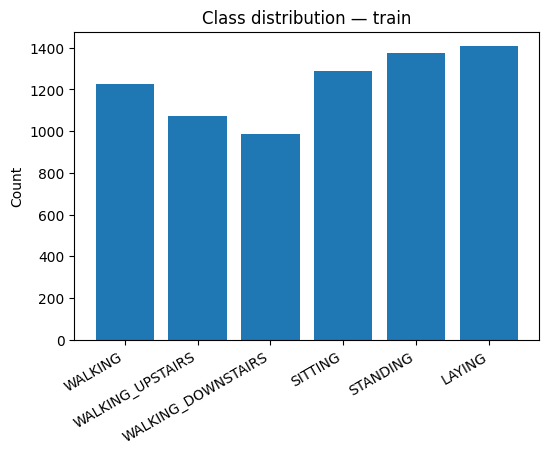

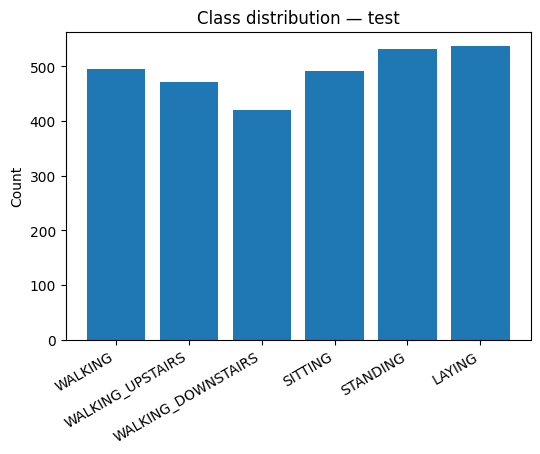

Train counts: [1226 1073  986 1286 1374 1407]
Test counts : [496 471 420 491 532 537]


In [7]:
import matplotlib.pyplot as plt

def plot_class_distribution(y, split="train"):
    counts = np.bincount(y, minlength=NUM_CLASSES)
    plt.figure(figsize=(6,4))
    plt.bar(range(NUM_CLASSES), counts, tick_label=[ACTIVITY_MAP[i] for i in range(NUM_CLASSES)])
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Count")
    plt.title(f"Class distribution — {split}")
    plt.show()
    return counts

train_counts = plot_class_distribution(y_train, split="train")
test_counts  = plot_class_distribution(y_test,  split="test")

print("Train counts:", train_counts)
print("Test counts :", test_counts)


**Reflection: Class balance**

The dataset is fairly **balanced across the six activities**, with each class contributing a few hundred sequences.  
This means our RNN is not biased by extreme imbalance, but some activities (like **WALKING_DOWNSTAIRS**) still have fewer samples.  

⚡ Implication: The model might perform slightly worse on under-represented classes, and we should keep this in mind when analyzing per-class errors in later sections.

---


📘 Instruction</br>
Build a train DataLoader with a different batch size (e.g., 48). Use the already prepared tensors X_train_t, y_train_t.


In [8]:
# CT_Task 1 — New train DataLoader with a different batch size

from torch.utils.data import TensorDataset, DataLoader

CT_BATCH_SIZE_TRAIN = 48   # e.g., 48
CT_train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),   # X_train_t, y_train_t
    batch_size=CT_BATCH_SIZE_TRAIN,
    shuffle=True,
    drop_last=False
)

# sanity check one batch
CT_xb, CT_yb = next(iter(CT_train_loader))
print("CT_train batch shapes:", CT_xb.shape, CT_yb.shape)


CT_train batch shapes: torch.Size([48, 128, 9]) torch.Size([48])


📘Instruction</br>

Build a test DataLoader with a different batch size (e.g., 64). Use X_test_t, y_test_t.


In [9]:
# CT_Task 2 — New test DataLoader with a different batch size

from torch.utils.data import TensorDataset, DataLoader

CT_BATCH_SIZE_TEST = 64   # e.g., 64
CT_test_loader = DataLoader(
    TensorDataset(X_test_t, y_test_t),   # X_test_t, y_test_t
    batch_size=CT_BATCH_SIZE_TEST,
    shuffle=False,
    drop_last=False
)

# sanity check one batch
CT_xb_test, CT_yb_test = next(iter(CT_test_loader))
print("CT_test batch shapes:", CT_xb_test.shape, CT_yb_test.shape)


CT_test batch shapes: torch.Size([64, 128, 9]) torch.Size([64])


📘Instruction</br>
Create a fresh RNNClassifier named CT_model_loaded with hidden_size=32 (to match saved weights), then load rnn_har.pth and set to eval().

ℹ️ Note: Changing hidden_size breaks weight loading. If you want a different hidden size, create a separate model without loading the old weights.


In [10]:
# CT_Task 3 — Create RNN and load saved weights (hidden_size must match)

import torch
import torch.nn as nn

CT_model_loaded = RNNClassifier(
    input_size= 9,
    hidden_size= 32,     # must be 32 to load rnn_har.pth safely
    num_classes=6,
    num_layers=1,
    nonlinearity="tanh"
)
CT_state = torch.load("rnn_har.pth", map_location="cpu", weights_only=False)
CT_model_loaded.load_state_dict(CT_state)
CT_model_loaded.eval()

# quick forward to confirm shapes
CT_xb, CT_yb = next(iter(CT_train_loader))
with torch.no_grad():
    CT_logits, CT_out_seq, CT_hn = CT_model_loaded(CT_xb)
print("CT_out_seq shape:", CT_out_seq.shape)


CT_out_seq shape: torch.Size([48, 128, 32])


---

### **3. Vanishing Gradients**

**Theory: Why do gradients vanish?**

When training RNNs, we use **Backpropagation Through Time (BPTT)**:  
- Gradients flow backward through all timesteps (here, 128).  
- At each step, the gradient is multiplied by terms from the chain rule.  

If those terms are **smaller than 1**, the product shrinks **exponentially** with the number of timesteps.  
This leads to the **vanishing gradient problem**:

- Early timesteps contribute almost nothing to the final weight update.  
- The RNN struggles to capture **long-term dependencies**.  
- Training focuses mostly on the most recent steps.  

This is one of the main reasons more advanced architectures (LSTM/GRU) were developed.




In [11]:
# One training step to measure gradient norms

import torch
import torch.nn as nn

# Recreate model (same as Section 2)
model = RNNClassifier(input_size=9, hidden_size=32, num_classes=6, num_layers=1, nonlinearity="tanh")
model.load_state_dict(torch.load("rnn_har.pth", map_location="cpu", weights_only=False))
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Take one mini-batch
xb, yb = next(iter(train_loader))

# Forward pass
logits, out_seq, h_n = model(xb)
loss = criterion(logits, yb)

# Backward pass
optimizer.zero_grad()
loss.backward()

# Collect gradient norms
grad_norms = {}
for name, param in model.named_parameters():
    if param.grad is not None:
        grad_norms[name] = param.grad.norm().item()

grad_norms


{'rnn.weight_ih_l0': 0.25536012649536133,
 'rnn.weight_hh_l0': 1.1206583976745605,
 'rnn.bias_ih_l0': 0.25601112842559814,
 'rnn.bias_hh_l0': 0.25601109862327576,
 'fc.weight': 0.23975840210914612,
 'fc.bias': 0.0544147789478302}

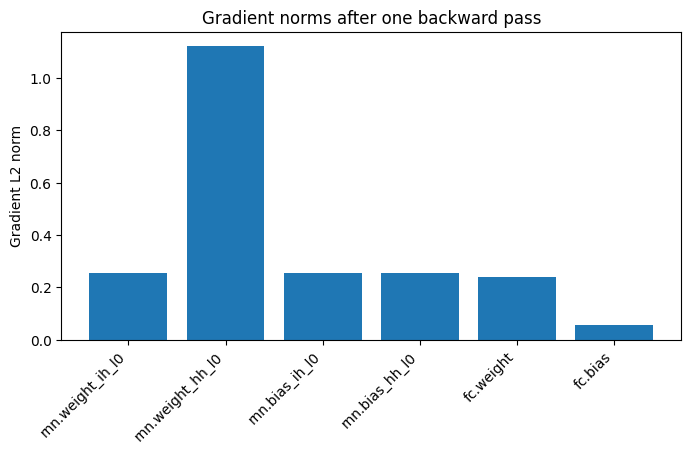

In [12]:
# Visualize gradient magnitudes

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(range(len(grad_norms)), list(grad_norms.values()), tick_label=list(grad_norms.keys()))
plt.ylabel("Gradient L2 norm")
plt.title("Gradient norms after one backward pass")
plt.xticks(rotation=45, ha="right")
plt.show()


> **Note on `fc.weight` and `fc.bias`:**  
> 
> - In our model, the RNN outputs the final hidden state $h_{128} \in \mathbb{R}^{32}$.  
> - The **fully connected (fc) layer** maps this hidden vector to 6 activity classes:  
>   $$
>   \text{logits} = W \cdot h_{128} + b
>   $$
>   where `fc.weight = W` (shape: 6×32) and `fc.bias = b` (shape: 6).  
> - During backprop, the gradient flows first into this FC layer, then into the hidden state, and finally back through all timesteps of the RNN.  
> - That’s why you see `fc.weight` and `fc.bias` among the parameters — they usually have **healthy gradient magnitudes**, since they are directly connected to the loss, while the **recurrent weights** (`rnn.weight_hh_l0`) are where the vanishing gradient problem shows up.


**Reflection**

- Notice how some parameters (like **hidden-to-hidden weights**) may have **much smaller gradients** than others.  
- If we repeated this over many updates, we’d often see gradients shrink towards **zero**, especially for early timesteps.  
- This is direct evidence of the **vanishing gradient problem** in vanilla RNNs.  

👉 **Think about it:**  
- Why would this make it hard for the RNN to remember something from timestep $t=1$ when predicting at $t=128$?  
- What kind of activities in HAR might be most affected by this (e.g., transitions, long-duration signals)?

>This plot shows the gradient magnitudes for different parameter groups after one backward pass. Notice the recurrent weights (weight_hh_l0) dominate — the model is heavily adjusting how memory >flows through time.<br>
>But remember: this does not directly reveal the vanishing gradient problem. To really see vanishing gradients, we would need to track how the gradients decay timestep by timestep inside the
unrolled RNN. That’s what we’ll attempt next. This plot is a first diagnostic — it tells us where the updates concentrate, but not how far the gradients actually travel back in time.

**Measure how much the final loss “pulls” on each input timestep**

We now estimate the **timestep-wise sensitivity**:

$$
\left\| \frac{\partial \mathcal{L}}{\partial x_t} \right\|_2
$$



First 10 timestep input-grad norms: tensor([3.7589e-06, 1.7786e-06, 9.7914e-07, 7.0402e-07, 5.9936e-07, 5.7877e-07,
        6.2744e-07, 7.5074e-07, 9.6966e-07, 1.2887e-06])


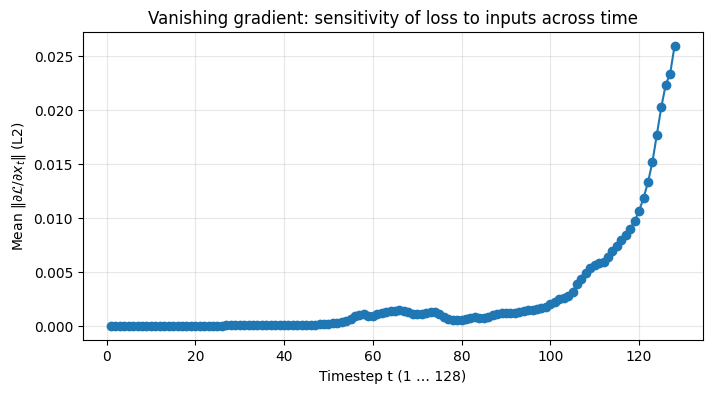

In [13]:
# Measure how much the final loss "pulls" on each input timestep
model.train()

xb, yb = next(iter(train_loader))
xb = xb.clone().detach().requires_grad_(True)  # (B, 128, 9) — enable grad on inputs

logits, out_seq, h_n = model(xb)               # loss depends ONLY on last hidden via logits
criterion = torch.nn.CrossEntropyLoss()
loss = criterion(logits, yb)

model.zero_grad()
loss.backward()                                 # single backward pass from t=128

# Gradients wrt inputs: shape (B, T, F). Reduce over batch & channels → (T,)
import torch
grad_x = xb.grad.detach()                       # (B, 128, 9)
grad_x_norm_per_t = torch.linalg.vector_norm(grad_x, dim=(0, 2))  # (T,)

print("First 10 timestep input-grad norms:", grad_x_norm_per_t[:10])

import matplotlib.pyplot as plt
T = grad_x_norm_per_t.numel()
plt.figure(figsize=(8,4))
plt.plot(range(1, T+1), grad_x_norm_per_t.numpy(), marker="o")
plt.xlabel("Timestep t (1 … 128)")
plt.ylabel(r"Mean $\|\partial \mathcal{L} / \partial x_t\|$ (L2)")
plt.title("Vanishing gradient: sensitivity of loss to inputs across time")
plt.grid(True, alpha=0.3)
plt.show()


**Interpreting the “vanishing gradient vs. timestep” plot**

**What we plotted.**  
For each timestep $t \in \{1,\dots,128\}$, we computed the average gradient magnitude:
$$
\Big\|\tfrac{\partial \mathcal{L}}{\partial x_t}\Big\|_2,
$$
where the loss $\mathcal{L}$ is computed only at the **final** timestep ($t=128$).  

This measures: *“If input $x_t$ changes slightly, how much does the final loss change?”*


**Why early timesteps have tiny gradients**

An RNN updates its hidden state step by step:
$$
h_t = \tanh(W_{ih} x_t + W_{hh} h_{t-1} + b), \quad
\hat{y} = \mathrm{softmax}(W_{hy} h_{128}).
$$

Now imagine the chain rule in action:

- For $t=127$:  
  $$
  \tfrac{\partial \mathcal{L}}{\partial x_{127}}
  \;\approx\; \alpha \cdot \tfrac{\partial \mathcal{L}}{\partial h_{128}}
  $$
  where $\alpha$ is some slope from $\tanh$ and weights ($<1$ in size).  
  → Gradient still strong, because it’s only 1 step away.

- For $t=100$:  
  $$
  \tfrac{\partial \mathcal{L}}{\partial x_{100}}
  \;\approx\; \alpha^{28} \cdot \tfrac{\partial \mathcal{L}}{\partial h_{128}}
  $$
  → Same shrink factor applied **28 times**. Much smaller.

- For $t=1$:  
  $$
  \tfrac{\partial \mathcal{L}}{\partial x_{1}}
  \;\approx\; \alpha^{127} \cdot \tfrac{\partial \mathcal{L}}{\partial h_{128}}
  $$
  → Tiny. The signal has almost disappeared.

So the further back we go, the more multiplications of “numbers less than 1” we accumulate, and the gradient almost vanishes.

**What the curve shows**

- Near the end of the sequence, gradients are **large** → the model can learn from those inputs.  
- Earlier timesteps → gradients **decay toward 0** → the model effectively **forgets the distant past**.  
- This is the **vanishing gradient problem** in action: the network can’t use information from long ago because the learning signal fades away before it gets there.

**Intuition: Echoes that fade**

Think of the gradient signal like an **echo in a cave**:

- At $t=128$ (the end), you shout → the echo is loud.  
- At $t=120$, the echo has bounced a few times → it’s softer.  
- At $t=1$, it has bounced 127 times → almost nothing is left.

Mathematically, this is the same as multiplying a number less than 1 again and again:
$$
0.9 \times 0.9 \times 0.9 \times \dots \times 0.9 \;\;\to\;\; 0.
$$

So even if the **first input $x_1$ was important**, the network can’t “hear” its echo during training — the gradient is too weak to adjust the weights.  

This is why vanilla RNNs **struggle with long-term memory** and why more advanced models (LSTM, GRU) were invented.


**Hidden states “converging too soon” (early stagnation)**

If the hidden state barely changes after some early step, the RNN has stopped updating its memory long before the sequence ends.



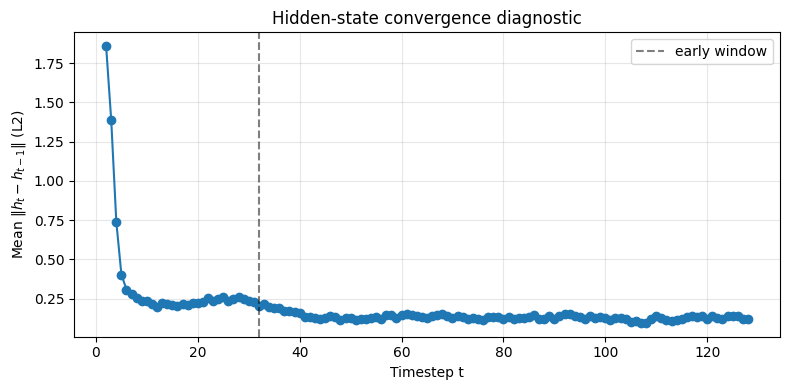

Fraction of early timesteps with near-zero hidden change: 0.00 (threshold ~ 6.84e-03)


In [14]:
# Hidden-state convergence diagnostic: mean ||h_t - h_{t-1}|| over batch
model.eval()
with torch.no_grad():
    xb_eval, _ = next(iter(test_loader))         # (B, T, F)
    logits_eval, out_seq_eval, _ = model(xb_eval)  # out_seq_eval: (B, T, H)

# Step-to-step hidden change: (B, T-1, H) -> mean L2 over batch
delta = out_seq_eval[:, 1:, :] - out_seq_eval[:, :-1, :]
delta_norm_t = torch.linalg.vector_norm(delta, dim=2).mean(dim=0)  # (T-1,)

plt.figure(figsize=(8,4))
plt.plot(range(2, T+1), delta_norm_t.numpy(), marker="o")
plt.axvline(x=(T//4), color="k", ls="--", alpha=0.5, label="early window")
plt.xlabel("Timestep t")
plt.ylabel(r"Mean $\|h_t - h_{t-1}\|$ (L2)")
plt.title("Hidden-state convergence diagnostic")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Quantify early stagnation relative to the distribution of changes
th = float(0.05 * torch.median(delta_norm_t).item()) if delta_norm_t.numel() else 1e-3
early_plateau_frac = float((delta_norm_t[:(T//4 - 1)] < th).float().mean().item()) if T > 4 else 0.0
print(f"Fraction of early timesteps with near-zero hidden change: {early_plateau_frac:.2f} (threshold ~ {th:.2e})")


**Hidden State Dynamics and Early Convergence**

If 

$$
\left\| h_t - h_{t-1} \right\|
$$

quickly drops near zero and stays low, we’re **converging too soon**.

- In **dynamic activities** (e.g., `WALKING`, `WALKING_UPSTAIRS`, `WALKING_DOWNSTAIRS`), we’d expect **continued hidden updates**; early stagnation is **harmful**.
- In **static activities** (`SITTING`, `STANDING`, `LAYING`), some **stabilization** is expected — but not if it **prevents us from detecting transitions**.

---


📘Instruction</br> 
Using CT_model_loaded and your new CT_train_loader, compute per-timestep input gradient norms and store in CT_grad_x_norm_per_t. Plot the curve and a dashed threshold line.


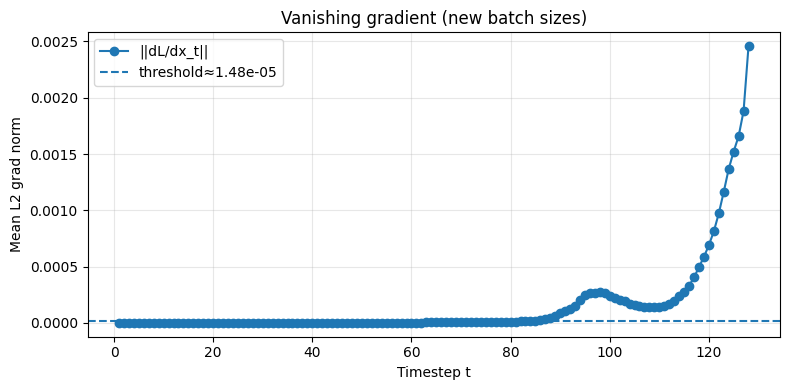

In [15]:
# CT_Task 4 — Vanishing gradient plot with new config

# one mini-batch from CT_train_loader
CT_xb_grad, CT_yb_grad = next(iter(CT_train_loader))
CT_xb_grad = CT_xb_grad.clone().detach().requires_grad_(True)

CT_model_loaded.train()
CT_logits_g, CT_out_seq_g, CT_hn_g = CT_model_loaded(CT_xb_grad)
CT_loss_g = nn.CrossEntropyLoss()(CT_logits_g, CT_yb_grad)

CT_model_loaded.zero_grad()
CT_loss_g.backward()

# mean L2 norm over features, then mean over batch -> (T,)
CT_grad_x = CT_xb_grad.grad.detach()          # (B, T, F)
CT_grad_x_norm_per_t = torch.linalg.vector_norm(CT_grad_x, dim=2).mean(dim=0)  # fill axis

# dynamic threshold vs last 8 steps
T = CT_grad_x_norm_per_t.numel()
CT_late_ref = CT_grad_x_norm_per_t[-8:].mean().item()
CT_vanish_thresh = float(0.01 * CT_late_ref) if CT_late_ref > 0 else 1e-4

plt.figure(figsize=(8,4))
plt.plot(range(1, T+1), CT_grad_x_norm_per_t.numpy(), marker="o", label="||dL/dx_t||")
plt.axhline(CT_vanish_thresh, ls="--", label=f"threshold≈{CT_vanish_thresh:.2e}")
plt.xlabel("Timestep t")
plt.ylabel("Mean L2 grad norm")
plt.title("Vanishing gradient (new batch sizes)")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.show()


📘Instruction:</br>
With CT_model_loaded.eval() and your CT_test_loader, compute mean step-to-step hidden change ||h_t − h_{t-1}|| across the batch to obtain CT_delta_norm_t (shape (127,)), then plot it and print the fraction of early timesteps with near-zero change.


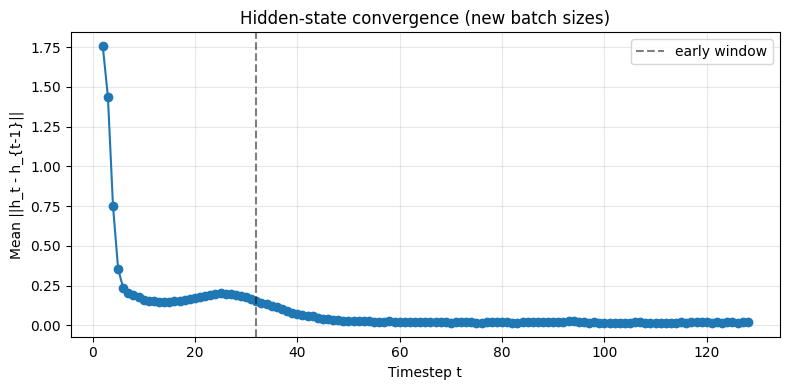

CT_early_plateau_frac: 0.00


In [16]:
# CT_Task 5 — Hidden-state convergence with new config

CT_model_loaded.eval()
with torch.no_grad():
    CT_xb_eval, _ = next(iter(CT_test_loader))
    CT_logits_e, CT_out_seq_e, _ = CT_model_loaded(CT_xb_eval)   # (B, T, H)

# (B, T-1, H)
CT_delta = CT_out_seq_e[:, 1:, :] - CT_out_seq_e[:, :-1, :]
CT_delta_norm_t = torch.linalg.vector_norm(CT_delta, dim=2).mean(dim=0)  # fill axis

plt.figure(figsize=(8,4))
plt.plot(range(2, 128+1), CT_delta_norm_t.numpy(), marker="o")
plt.axvline(x=(128//4), color="k", ls="--", alpha=0.5, label="early window")
plt.xlabel("Timestep t")
plt.ylabel("Mean ||h_t - h_{t-1}||")
plt.title("Hidden-state convergence (new batch sizes)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

# early plateau fraction
CT_th = float(0.05 * torch.median(CT_delta_norm_t).item()) if CT_delta_norm_t.numel() else 1e-3
CT_early_plateau_frac = float((CT_delta_norm_t[:(128//4 - 1)] < CT_th).float().mean().item())
print(f"CT_early_plateau_frac: {CT_early_plateau_frac:.2f}")


---

### **4. Per-Class Performance**

**Overall accuracy first**
Before breaking things down, here’s the **overall test accuracy** across all 6 activities.  
At first glance this may look “good enough” — but the detailed per-class report below will show **which classes the model struggles with**.




In [17]:
# Quick overall test accuracy
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        logits, _, _ = model(xb)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total   += yb.size(0)

test_acc = correct / total
print(f"Overall Test Accuracy: {test_acc:.3f}")


Overall Test Accuracy: 0.848


At first glance this may look “good enough” — but the detailed per-class report below will show **which classes the model struggles with**.

**Why accuracy isn’t enough**

A single test accuracy number hides **which activities** we predict well and which we confuse.  
To diagnose this, we need **per-class metrics**:
- **Precision**: of the sequences we predicted as a class, how many were correct?
- **Recall**: of the sequences that truly belong to a class, how many did we catch?
- **F1**: harmonic mean of precision and recall (balances both).

We’ll also visualize a **confusion matrix** (rows = true class, columns = predicted class) to see where errors concentrate.

**Get predictions on the test set**

We’ll run the trained RNN on the whole test set, collect `y_true`, `y_pred`, and then compute metrics.



In [18]:
import torch
import numpy as np

# Assumes: model, test_loader, device, ACTIVITY_MAP already defined in §2
model.eval()

all_true = []
all_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits, _, _ = model(xb)             # (B, 6)
        preds = logits.argmax(dim=1)         # (B,)
        all_true.append(yb.cpu().numpy())
        all_pred.append(preds.cpu().numpy())

y_true = np.concatenate(all_true)            # shape (N_test,)
y_pred = np.concatenate(all_pred)            # shape (N_test,)

print("Collected predictions:", y_true.shape, y_pred.shape)


Collected predictions: (2947,) (2947,)


**Classification report (precision/recall/F1)**


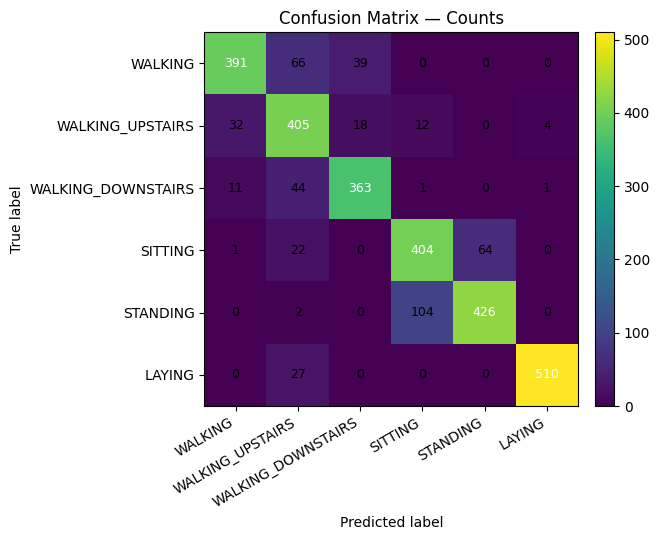

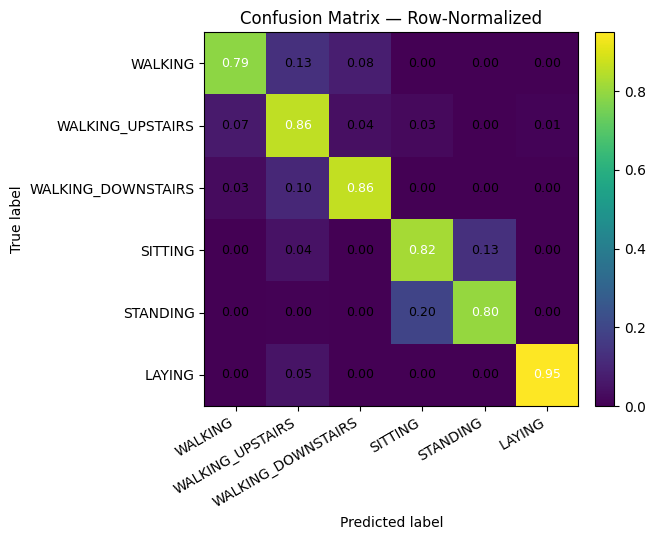

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(ACTIVITY_MAP))))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

def plot_confusion_matrix(matrix, labels, title, normalize=False):
    plt.figure(figsize=(6.5, 5.5))
    im = plt.imshow(matrix, interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=30, ha="right")
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)

    # Annotate cells
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            if normalize:
                txt = f"{val:.2f}"
            else:
                txt = f"{int(val)}"
            plt.text(j, i, txt, ha="center", va="center", fontsize=9, color="white" if matrix[i,j] > matrix.max()*0.6 else "black")
    plt.tight_layout()
    plt.show()

labels = [ACTIVITY_MAP[i] for i in range(len(ACTIVITY_MAP))]

plot_confusion_matrix(cm, labels, title="Confusion Matrix — Counts", normalize=False)
plot_confusion_matrix(cm_norm, labels, title="Confusion Matrix — Row-Normalized", normalize=True)


**How to read these results**

- **Per-class lines in the report**  
  - **Precision** high but **recall** lower → we’re conservative for that class (we’re right when we predict it, but we miss many true cases).  
  - **Recall** high but **precision** lower → we catch most true cases but also **over-predict** that class.

- **Row-normalized confusion matrix**  
  - Each row sums to 1 → a row shows how a **true class** is distributed among predictions.  
  - The **diagonal** is per-class **recall** (fraction correctly predicted).  
  - Off-diagonal entries show **specific confusions** (e.g., true **WALKING_UPSTAIRS** predicted as **WALKING**).

**Typical patterns for HAR**

- **Dynamic vs. dynamic**  
  - **WALKING**, **WALKING_UPSTAIRS**, **WALKING_DOWNSTAIRS** often confuse each other (similar rhythmic motion, overlapping frequency content).  
  - Expect off-diagonal mass among these three.

- **Static vs. static**  
  - **SITTING**, **STANDING**, **LAYING** can be easier but still show mix-ups (e.g., SITTING vs. STANDING), especially if the phone orientation adds noise.  
  - **LAYING** may be the cleanest of the three due to gravity orientation.

**What this tells us (and what to try next)**

- If a class has **low recall**, the model struggles to **detect** it → consider more capacity, better features, or a model that leverages longer context (LSTM/GRU).  
- If a class has **low precision**, the model **over-predicts** it → consider class weighting, data balance checks, or more discriminative representations.

These diagnostics set us up for **NB04 §5 (Investigating Confusions)** where we’ll:
1) pull **misclassified examples** (true vs. predicted), and  
2) **plot raw channels** to see why the signals look similar.

**Reflection prompts for us**

- Which two classes are **most confused**? Why might their raw signals look alike?  
- Does any class have **high precision but low recall** (or vice versa)? What does that imply about our decision boundary?  
- Would using **more timesteps** or **bidirectional RNNs** help separate the dynamic classes?  
- How might **LSTMs/GRUs** change these per-class metrics (think: better long-range memory, gated updates)?

---


### **5. Investigating Confusions**

**🧠 Why do classes overlap?**

Looking at the confusion matrix, we notice that:

- **WALKING vs. WALKING_UPSTAIRS** are often confused.  
- **SITTING vs. STANDING** have some overlap.  
- Static postures (e.g., LAYING) are much easier — almost no confusion.

This is not surprising:
- Walking and walking upstairs have **very similar sensor patterns** — both involve regular leg swings, with only subtle differences in vertical acceleration.  
- Sitting and standing can look alike unless there is a clear transition captured in the sequence.  
- Transition activities (like UPSTAIRS, DOWNSTAIRS) are inherently **ambiguous** — even humans sometimes disagree on labels.

**⚙️ Implementation: Inspect misclassified samples**

To dig deeper, we will:
1. Identify samples where the model’s **predicted label ≠ true label**.  
2. Select a few examples of these confusions.  
3. Plot their raw accelerometer/gyroscope signals (e.g., first 3 channels) over time.  

This will let us “see” why the model might get confused — are the signals truly similar?

**🔎 Reflection**
By visualizing misclassified signals:
- Students will see that **sensor patterns can be hard to distinguish** across similar activities.  
- The RNN isn’t “dumb” — the **data itself has overlapping patterns**, so errors are somewhat expected.  
- This naturally motivates why more sophisticated models (LSTMs, GRUs, CNNs) are often needed for HAR tasks.

---

### **6. Reflection on RNN Limitations**

**What we learned about vanilla RNNs**
So far, we’ve seen both strengths and weaknesses:

- **Vanishing gradients**  
  - Our gradient–timestep plots showed that signals from early timesteps contribute almost nothing to the final loss.  
  - This means the RNN struggles to learn dependencies that span **long sequences** (e.g., detecting a subtle pattern at $t=10$ that matters for classification at $t=128$).

- **Limited memory capacity**  
  - The model must compress all 128 timesteps into one final hidden state $h_{128}$.  
  - This "bottleneck" can cause the network to forget fine-grained details about the sequence.

- **Confusions in overlapping/transition activities**  
  - Our per-class analysis showed that similar activities (e.g., WALKING vs. WALKING_UPSTAIRS, SITTING vs. STANDING) are frequently confused.  
  - These cases require the model to **remember context over time**, something vanilla RNNs aren’t good at.

**Motivation for LSTM/GRU**
To overcome these limitations, more advanced recurrent architectures were developed:

- **LSTMs (Long Short-Term Memory)** introduce **gates** (input, forget, output) to control how information flows through time.  
- **GRUs (Gated Recurrent Units)** simplify this with fewer gates, but the same core idea.  
- Both architectures:  
  - Allow **better gradient flow** across long sequences.  
  - Provide a form of **selective memory** — the network can learn what to remember and what to forget.  

**Reflection prompts**
- Which HAR activities most clearly **require long-term memory**?  
  (e.g., distinguishing WALKING from WALKING_UPSTAIRS often requires several seconds of context).  
- Why might a **gated mechanism** help compared to a plain tanh recurrence?  
  (hint: it lets the network *decide* which information is worth keeping over many timesteps).

---

### **7. Summary & Bridge to Project 8**

**Key Lessons from this notebook**
- **Hidden states**: we visualized how they evolve, and saw their trajectories differ between static and dynamic activities.  
- **Vanishing gradients**: our empirical plots showed why early timesteps hardly contribute to learning.  
- **Per-class errors**: confusion matrices revealed systematic mistakes, especially in overlapping and transition activities.  

Together, these results show that **vanilla RNNs hit a ceiling**: they can model short-term patterns but struggle with long dependencies and ambiguous activities.

**Bridge to Project 8**
In the next notebook, we’ll introduce **LSTMs and GRUs**:  
- Architectures explicitly designed to solve vanishing gradients.  
- With **gating mechanisms** that provide longer-term memory and better performance in sequential tasks like HAR.

This will let us **build on what we diagnosed here** and move toward more powerful sequence models.

---
